In [66]:
# Get all the modules into our path.
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import machine learning modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
import analysis as ana
from analysis import helper as hp

# Import data processing modules.
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

# Import some extra modules
import re

# Import data visualisation modules.
import matplotlib.pyplot as plt

In [67]:
# Port in and unpack all the runs we need from the .pkl file.
TrainSet_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-16_bfm_5-3_1D_FB_100oc-100bar/completed_run.pkl')

In [68]:
# Filter all errored files out of the dictionary
dataset_dict, error_dict = hp.filter_errors(TrainSet_dict)

Returned 14556 files without errors out of a total possible 16000.
1444 files had errors.
0 files had unhandled errors.
File failure rate: 9.920307776861776 %.
To see unhandled errors, run with verbose=True.


In [96]:
# Get a df of all the start attributes of interest
attributes_all_df = attr.get_condition(dataset_dict,"f_i_onehundred",species_concs=True)
attributes_all_df = attributes_all_df.loc[:, ["HCO3-","Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)"]]
attributes_all_df

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)


,HCO3-,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq)
0,6.959850,0.008639,0.009236,0.008412,0.011782,0.000901,0.018781,0.018063
1,0.362034,0.019889,0.006757,0.014766,0.015169,0.019101,0.012283,0.019721
2,1.727252,0.016818,0.006918,0.013390,0.000664,0.007003,0.009433,0.008969
3,3.691655,0.012079,0.000125,0.009366,0.015292,0.017273,0.018103,0.000800
4,0.271405,0.014512,0.018235,0.012059,0.019059,0.012268,0.017185,0.014145
...,...,...,...,...,...,...,...,...
14551,3.076317,0.017831,0.011572,0.018447,0.004185,0.000735,0.009735,0.004838
14552,3.847435,0.004883,0.013111,0.017648,0.009385,0.004792,0.019129,0.015238
14553,1.981378,0.018599,0.003749,0.019024,0.019137,0.015390,0.016777,0.015538
14554,7.734595,0.008684,0.002643,0.011963,0.010950,0.006106,0.012260,0.008428


In [97]:
# Get an array of the end carbonate volumes generated
NonCalSidMag_arr = ["Diopside","Diopside_a","Hedenbergite","Hedenbergite_a",
                    "Albite","Albite_a","Anorthite","Anorthite_a","M_Microcline",
                    "M_Microcline_a","M_Microcline_b","Forsterite","Forsterite_a",
                    "Fayalite","Fayalite_a","Antigorite","Antigorite_a","Greenalite",
                    "Greenalite_a","Calcite_a","Siderite_a","Magnesite_a"]
CalSidMag_arr = ["Calcite","Siderite","Magnesite"]

Vols_ds = lbls.raw(dataset_dict, 'volume')
NrXDiscretisedBlocks = len(Vols_ds.X.values)
EndVols_ds = Vols_ds.sel(time=280.0)
CalSidMagEndVols_ds = EndVols_ds.drop(labels=NonCalSidMag_arr)

CalSidMagEndVols_da = CalSidMagEndVols_ds.to_array(dim='arbitrary_array')
CalSidMagEndVols_da = CalSidMagEndVols_da.astype(str)
CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+-\d+$", "0", regex=True)
CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+\+\d+$", "5000.0000", regex=True)
CalSidMagEndVols_da = CalSidMagEndVols_da.astype(float)

CalSidMagEndVols_ds = CalSidMagEndVols_da.to_dataset(dim="arbitrary_array")
SpatialSummedCalSidMagEndVols_ds = CalSidMagEndVols_ds.sum(dim=["X","Y","Z"])
SpatialSummedCarbEndVols_ds = SpatialSummedCalSidMagEndVols_ds.assign(Carbonates=lambda SpatialSummedCalSidMagEndVols_ds: SpatialSummedCalSidMagEndVols_ds.Calcite + SpatialSummedCalSidMagEndVols_ds.Siderite + SpatialSummedCalSidMagEndVols_ds.Magnesite)
# SpatialSummedCarbEndVols_ds = SpatialSummedCarbEndVols_ds.drop(labels=CalSidMag_arr)
SpatialSummedCalEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Calcite.values)
SpatialSummedSidEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Siderite.values)
SpatialSummedMagEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Magnesite.values)
SpatialSummedCarbEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Carbonates.values)

In [98]:
attributes_all_df["Calcite_sum"] = SpatialSummedCalEndVols_arr.tolist()
attributes_all_df["Siderite_sum"] = SpatialSummedSidEndVols_arr.tolist()
attributes_all_df["Magnesite_sum"] = SpatialSummedMagEndVols_arr.tolist()
attributes_all_df["Carbonates_sum"] = SpatialSummedCarbEndVols_arr.tolist()
attributes_all_df

,HCO3-,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Calcite_sum,Siderite_sum,Magnesite_sum,Carbonates_sum
0,6.959850,0.008639,0.009236,0.008412,0.011782,0.000901,0.018781,0.018063,5.232691e+00,2.406719e+00,6.115084e-08,7.639410e+00
1,0.362034,0.019889,0.006757,0.014766,0.015169,0.019101,0.012283,0.019721,1.000001e-10,1.491808e-08,1.007800e-08,2.509608e-08
2,1.727252,0.016818,0.006918,0.013390,0.000664,0.007003,0.009433,0.008969,2.813123e+00,3.037259e-05,2.110895e-08,2.813153e+00
3,3.691655,0.012079,0.000125,0.009366,0.015292,0.017273,0.018103,0.000800,5.187950e+00,4.028654e+00,6.272094e-08,9.216605e+00
4,0.271405,0.014512,0.018235,0.012059,0.019059,0.012268,0.017185,0.014145,2.260755e-01,3.179954e-02,8.381302e-02,3.416881e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
14551,3.076317,0.017831,0.011572,0.018447,0.004185,0.000735,0.009735,0.004838,5.015285e+00,9.149040e-01,4.925211e-08,5.930189e+00
14552,3.847435,0.004883,0.013111,0.017648,0.009385,0.004792,0.019129,0.015238,5.136426e+00,2.412140e-01,5.196561e-08,5.377640e+00
14553,1.981378,0.018599,0.003749,0.019024,0.019137,0.015390,0.016777,0.015538,2.680103e+00,9.038895e-05,2.406261e-08,2.680194e+00
14554,7.734595,0.008684,0.002643,0.011963,0.010950,0.006106,0.012260,0.008428,5.371996e+00,3.757135e+00,8.032306e-08,9.129131e+00


In [127]:
attributes_cleaned_df = attributes_all_df
attributes_cleaned_df.loc[attributes_cleaned_df['Calcite_sum'] > (1*NrXDiscretisedBlocks), 'Calcite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Siderite_sum'] > (1*NrXDiscretisedBlocks), 'Siderite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Magnesite_sum'] > (1*NrXDiscretisedBlocks), 'Magnesite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Carbonates_sum'] > (1*NrXDiscretisedBlocks), 'Carbonates_sum'] = np.nan

attributes_cleaned_df.loc[attributes_cleaned_df['Calcite_sum'] == np.inf, 'Calcite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Siderite_sum'] == np.inf, 'Siderite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Magnesite_sum'] == np.inf, 'Magnesite_sum'] = np.nan
attributes_cleaned_df.loc[attributes_cleaned_df['Carbonates_sum'] == np.inf, 'Carbonates_sum'] = np.nan

attributes_cleaned_df = attributes_cleaned_df.dropna()
attributes_cleaned_df = attributes_cleaned_df.reset_index()

attributes_cleaned_df["Calcite_avg"] = (attributes_cleaned_df["Calcite_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Siderite_avg"] = (attributes_cleaned_df["Siderite_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Magnesite_avg"] = (attributes_cleaned_df["Magnesite_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df["Carbonates_avg"] = (attributes_cleaned_df["Carbonates_sum"] / NrXDiscretisedBlocks)
attributes_cleaned_df = attributes_cleaned_df.drop(['Calcite_sum', 'Siderite_sum', 'Magnesite_sum', 'Carbonates_sum'], axis=1)

attributes_cleaned_df["Calcite_pct"] = (attributes_cleaned_df["Calcite_avg"] / 1) * 100
attributes_cleaned_df["Siderite_pct"] = (attributes_cleaned_df["Siderite_avg"] / 1) * 100
attributes_cleaned_df["Magnesite_pct"] = (attributes_cleaned_df["Magnesite_avg"] / 1) * 100
attributes_cleaned_df["Carbonates_pct"] = (attributes_cleaned_df["Carbonates_avg"] / 1) * 100
attributes_cleaned_df = attributes_cleaned_df.drop(['Calcite_avg', 'Siderite_avg', 'Magnesite_avg', 'Carbonates_avg'], axis=1)
attributes_cleaned_df

,index,HCO3-,Al+++,Ca++,Fe++,K+,Na+,Mg++,SiO2(aq),Calcite_pct,Siderite_pct,Magnesite_pct,Carbonates_pct
0,0,6.959850,0.008639,0.009236,0.008412,0.011782,0.000901,0.018781,0.018063,3.442560e+00,1.583368e+00,4.023082e-08,5.025928e+00
1,1,0.362034,0.019889,0.006757,0.014766,0.015169,0.019101,0.012283,0.019721,6.578952e-11,9.814526e-09,6.630265e-09,1.651058e-08
2,2,1.727252,0.016818,0.006918,0.013390,0.000664,0.007003,0.009433,0.008969,1.850739e+00,1.998197e-05,1.388747e-08,1.850759e+00
3,3,3.691655,0.012079,0.000125,0.009366,0.015292,0.017273,0.018103,0.000800,3.413125e+00,2.650431e+00,4.126378e-08,6.063556e+00
4,4,0.271405,0.014512,0.018235,0.012059,0.019059,0.012268,0.017185,0.014145,1.487339e-01,2.092075e-02,5.514014e-02,2.247948e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14546,14551,3.076317,0.017831,0.011572,0.018447,0.004185,0.000735,0.009735,0.004838,3.299529e+00,6.019106e-01,3.240270e-08,3.901440e+00
14547,14552,3.847435,0.004883,0.013111,0.017648,0.009385,0.004792,0.019129,0.015238,3.379228e+00,1.586934e-01,3.418790e-08,3.537921e+00
14548,14553,1.981378,0.018599,0.003749,0.019024,0.019137,0.015390,0.016777,0.015538,1.763226e+00,5.946642e-05,1.583067e-08,1.763285e+00
14549,14554,7.734595,0.008684,0.002643,0.011963,0.010950,0.006106,0.012260,0.008428,3.534208e+00,2.471799e+00,5.284412e-08,6.006007e+00


Text(0.5, 0, '[Mg++] (mol/kg)')

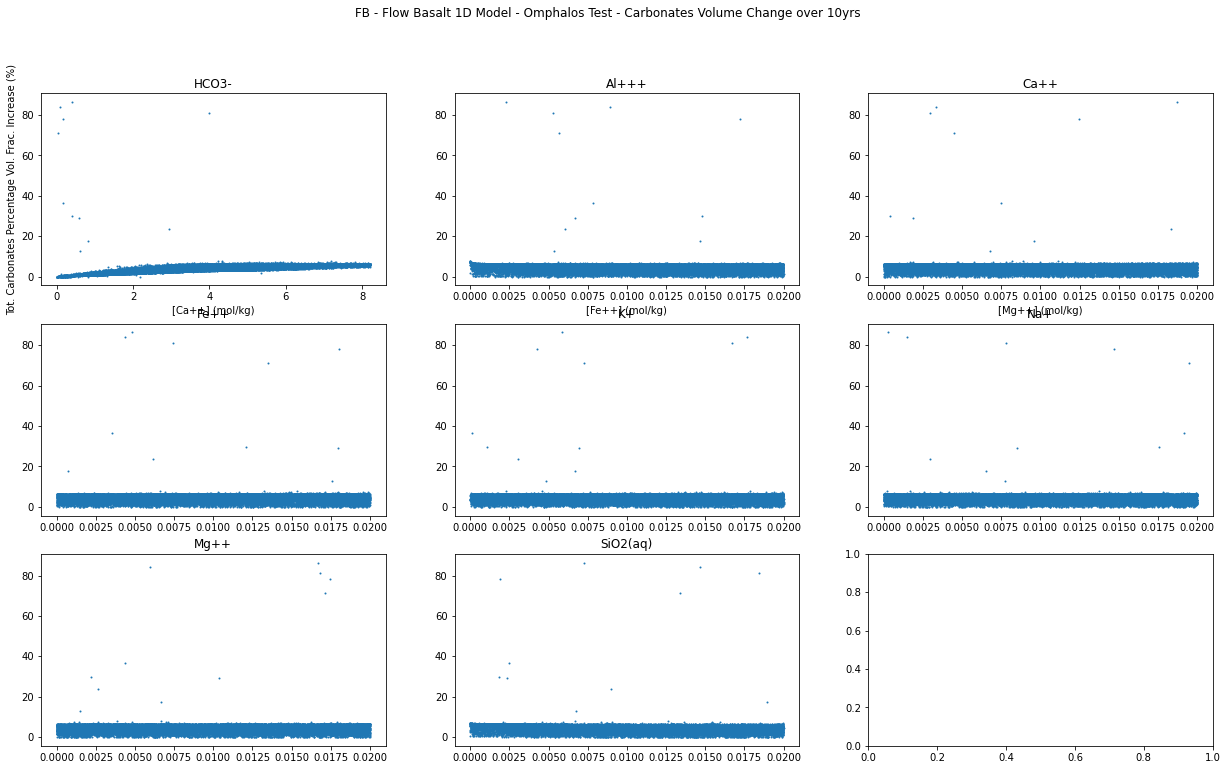

In [128]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Carbonates Volume Change over 10yrs')

fig.set_figheight(12)
fig.set_figwidth(21)

species = ["HCO3-","Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)"]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for species,axes in zip(species,axes):
    axes.set_title(species, loc='center')
    x = attributes_cleaned_df[species].values
    y = attributes_cleaned_df.Carbonates_pct.values
    axes.scatter(x=x, y=y, s=1, alpha=1)

ax1.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')

ax1.set_xlabel('[Ca++] (mol/kg)')
ax2.set_xlabel('[Fe++] (mol/kg)')
ax3.set_xlabel('[Mg++] (mol/kg)')

Text(0, 0.5, 'Tot. Carbonates Percentage Vol. Frac. Increase (%)')

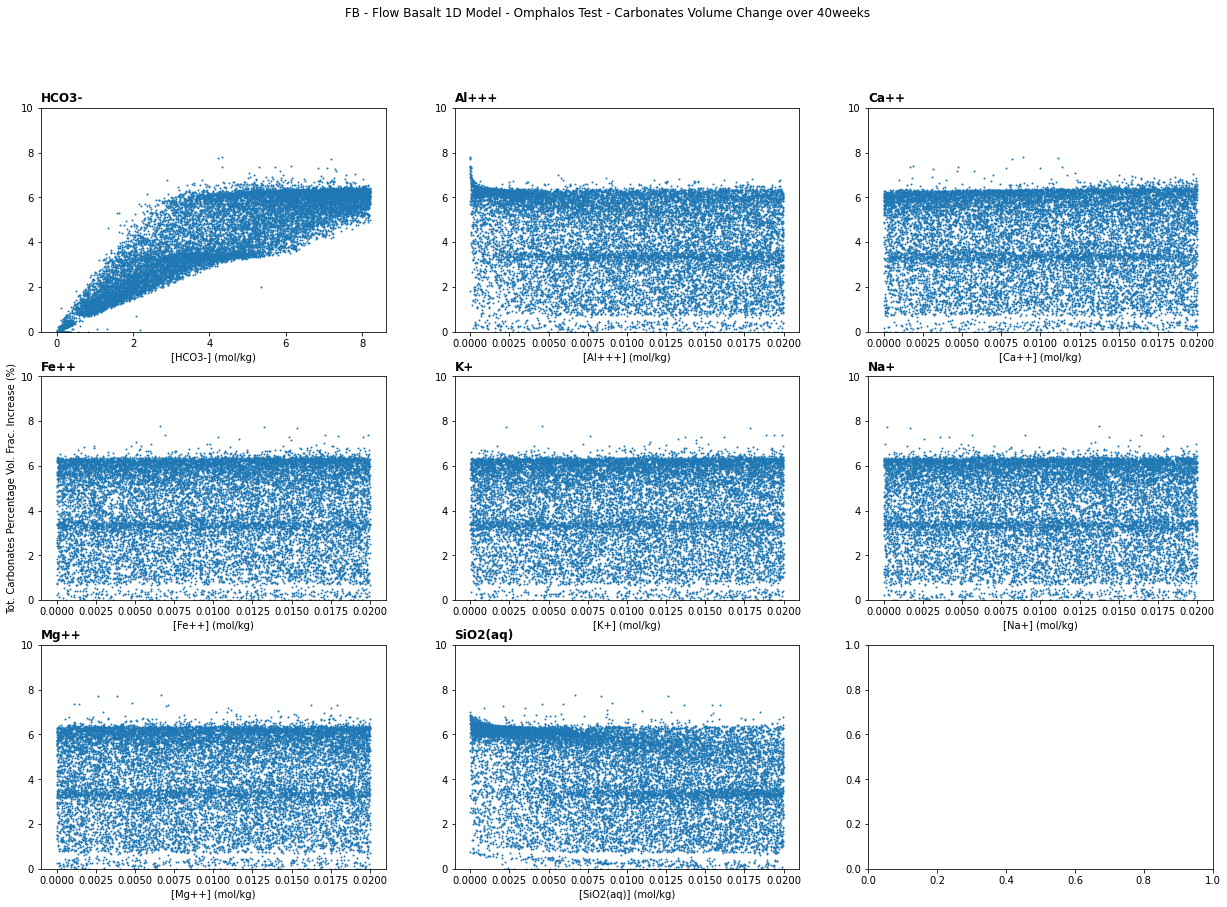

In [133]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Carbonates Volume Change over 40weeks')

fig.set_figheight(14)
fig.set_figwidth(21)

species = ["HCO3-","Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)"]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for species,axes in zip(species,axes):
    axes.set_title(species, loc='left',fontweight="bold")
    x = attributes_cleaned_df[species].values
    y = attributes_cleaned_df.Carbonates_pct.values
    axes.scatter(x=x, y=y, s=1, alpha=1)
    axes.set_xlabel(f'[{species}] (mol/kg)')
    axes.set_ylim(0, 10)

ax4.set_ylabel('Tot. Carbonates Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Calcite Percentage Vol. Frac. Increase (%)')

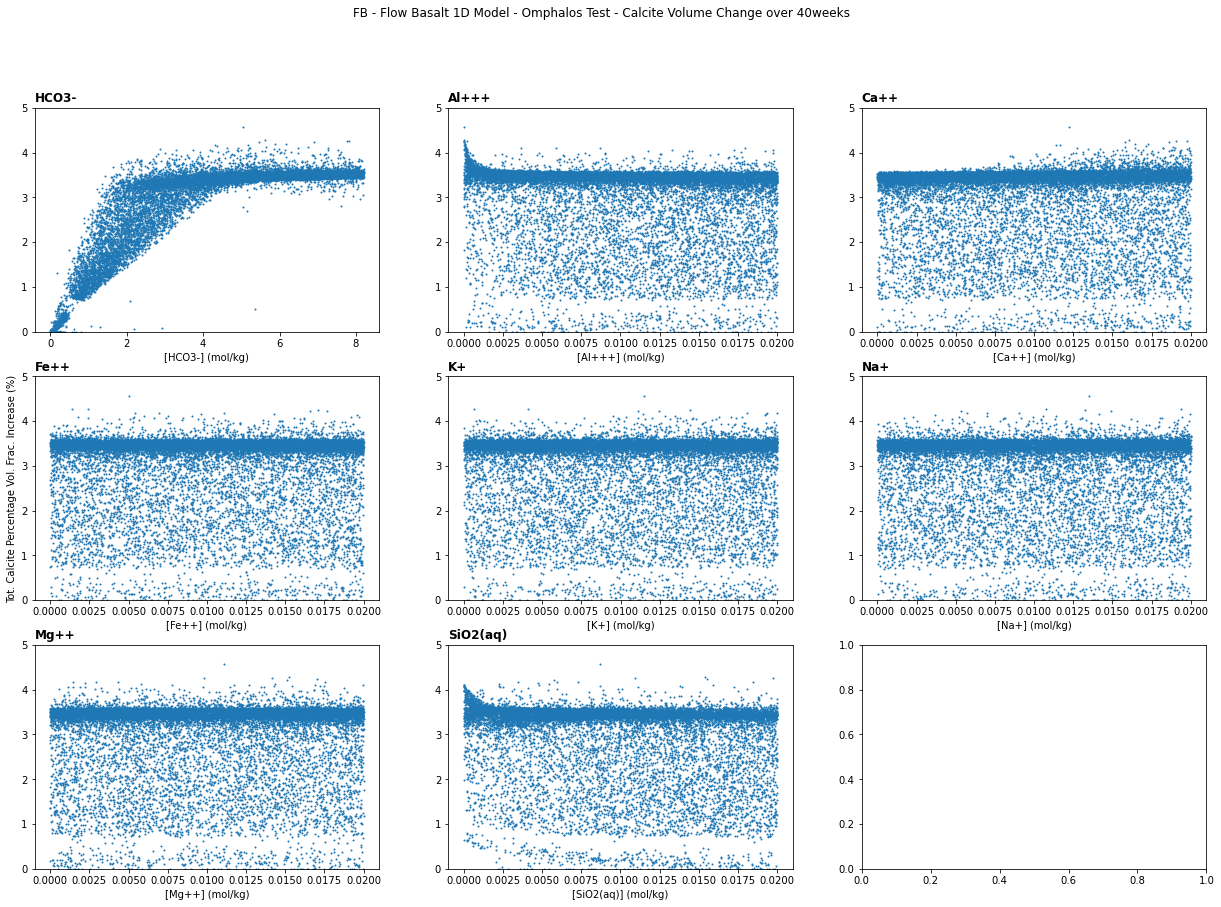

In [134]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Calcite Volume Change over 40weeks')

fig.set_figheight(14)
fig.set_figwidth(21)

species = ["HCO3-","Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)"]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for species,axes in zip(species,axes):
    axes.set_title(species, loc='left',fontweight="bold")
    x = attributes_cleaned_df[species].values
    y = attributes_cleaned_df.Calcite_pct.values
    axes.scatter(x=x, y=y, s=1, alpha=1)
    axes.set_xlabel(f'[{species}] (mol/kg)')
    axes.set_ylim(0, 5)

ax4.set_ylabel('Tot. Calcite Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Siderite Percentage Vol. Frac. Increase (%)')

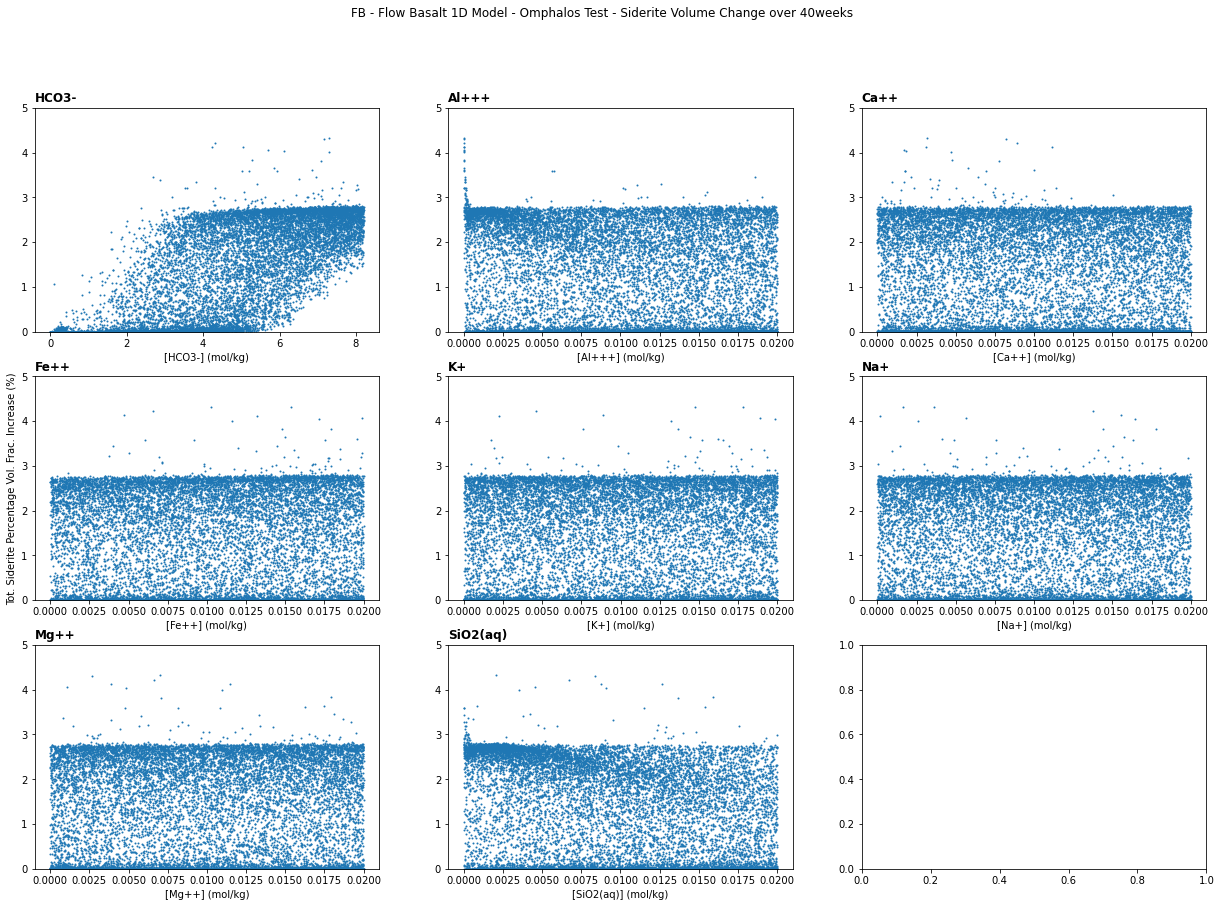

In [135]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Siderite Volume Change over 40weeks')

fig.set_figheight(14)
fig.set_figwidth(21)

species = ["HCO3-","Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)"]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for species,axes in zip(species,axes):
    axes.set_title(species, loc='left',fontweight="bold")
    x = attributes_cleaned_df[species].values
    y = attributes_cleaned_df.Siderite_pct.values
    axes.scatter(x=x, y=y, s=1, alpha=1)
    axes.set_xlabel(f'[{species}] (mol/kg)')
    axes.set_ylim(0, 5)

ax4.set_ylabel('Tot. Siderite Percentage Vol. Frac. Increase (%)')

Text(0, 0.5, 'Tot. Magnesite Percentage Vol. Frac. Increase (%)')

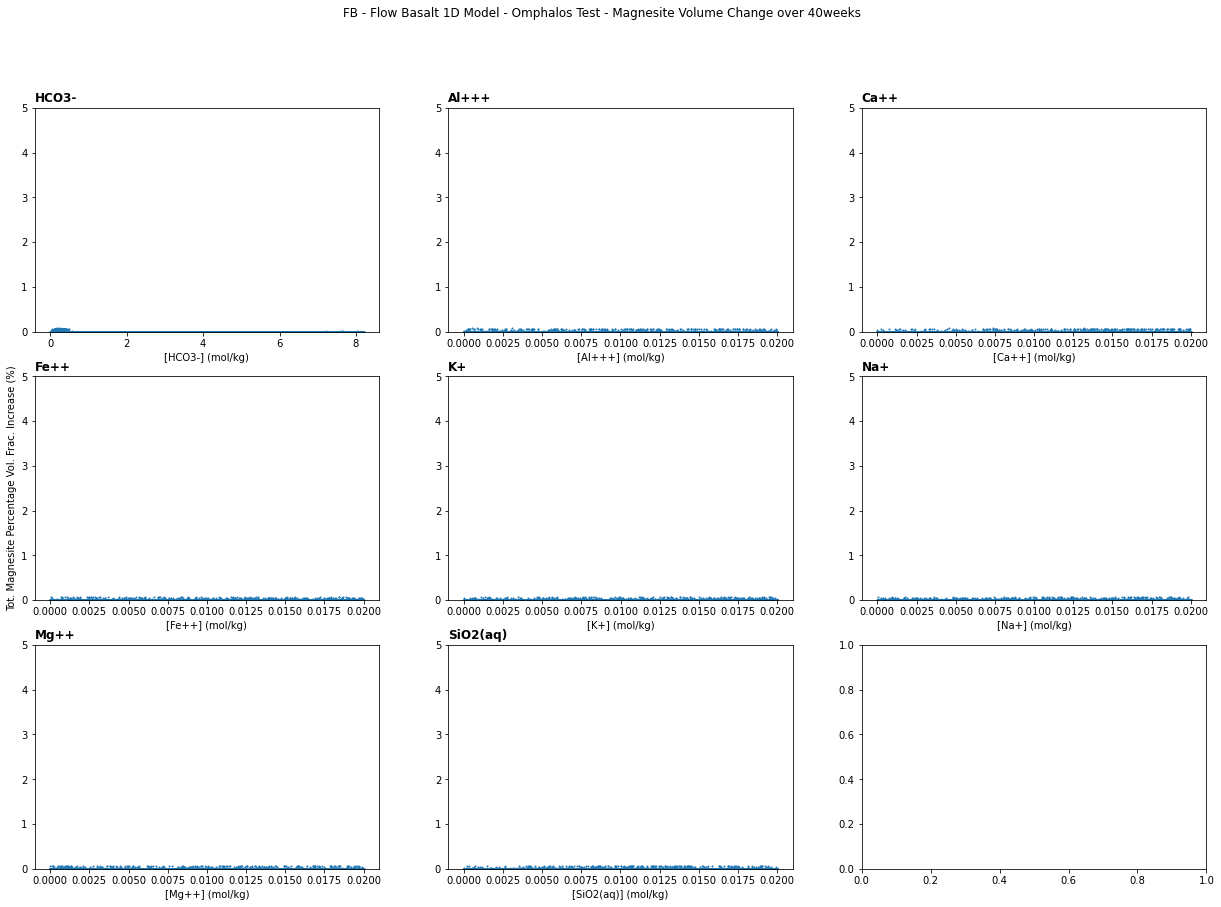

In [136]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3)
fig.suptitle('FB - Flow Basalt 1D Model - Omphalos Test - Magnesite Volume Change over 40weeks')

fig.set_figheight(14)
fig.set_figwidth(21)

species = ["HCO3-","Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)"]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for species,axes in zip(species,axes):
    axes.set_title(species, loc='left',fontweight="bold")
    x = attributes_cleaned_df[species].values
    y = attributes_cleaned_df.Magnesite_pct.values
    axes.scatter(x=x, y=y, s=1, alpha=1)
    axes.set_xlabel(f'[{species}] (mol/kg)')
    axes.set_ylim(0, 5)

ax4.set_ylabel('Tot. Magnesite Percentage Vol. Frac. Increase (%)')